In [7]:
import time

import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [8]:

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)


def SIR(x, param_inf, param_rec):
    """Function based on the following definition of SIR model:
    an healthy individual can be infected w.p. 1-(1-param_inf)^N where N are the infected neighbours around
    an infected individual can recover (and become immune) w.p. param_rec

    """
    x = x.unsqueeze(0) # Add a dimension to the starting grid
    # Define the 3x3 kernel with all values set to 1
    kernel = torch.ones(1, 1, 3, 3, dtype=torch.float32)

    # and middle value to 0
    kernel[0][0][1][1] = 0

    # Perform convolution
    neighbors_count = F.conv2d(x.float(), kernel, padding=1)

    bernoulli_param = 1-(1-param_inf)**neighbors_count

    ## add the feature that infected indivduals can recover w.p. param_rec

    random_uniform = torch.rand(x.size())
    #update susceptible cases to become infected
    y_pred = (bernoulli_param>=random_uniform).int()

    #update infected cases to become recovered
    y_pred[x == 1] = 1
    y_pred[x == 1] += (random_uniform[x==1]<=param_rec)

    #making sure that an healthy pixel with no neighbours doesnt get infected
    y_pred[neighbors_count==0] = 0
    # making sure that if a pixel recovered, stays as such
    y_pred[x==2] = 2

    return y_pred.type(torch.FloatTensor)

class StochasticLatticeDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (Tensor): Tensor containing the lattice data.
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_lattice = self.data[idx, 0]
        output_lattice = self.data[idx, 1]
        return input_lattice, output_lattice

In [9]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, sample_gumbel, temperature, paramInf, paramRec):
        """Forward function that makes use of Gumbel-Max trick to replicate the basic
        SIR model
        """

        batch_size = x.size()[0]
        x = x.reshape(batch_size,1,100,100) # Add a dimension to the starting grid

        # Define the 3x3 kernel with all values set to 1
        kernel = torch.ones(1, 1, 3, 3, dtype=torch.float32)
        # and middle value to 0
        kernel[0][0][1][1] = 0

        # Perform convolution
        neighbors_count = F.conv2d(x, kernel, padding=1).reshape(batch_size,100,100)
        x= x.reshape(batch_size,100,100)


        logits_input = (1-(1-paramInf)**neighbors_count)

        #the matrix of probabilities for individual in position x,y to go/stay to state 0 (susceptible) in the next time step
        suspectible_layer = torch.zeros(batch_size,100,100)
        suspectible_layer[x==0] = 1-logits_input[x==0]

        #the matrix of probabilities for individual in position x,y to go/stay to state 1 (infected) in the next time step
        infected_layer = torch.zeros(batch_size,100,100)
        infected_layer[x==0] = logits_input[x==0]
        infected_layer[x==1] = 1- paramRec

        #the matrix of probabilities for individual in position x,y to go/stay to state 2 (recovered) in the next time step
        recovered_layer = torch.zeros(batch_size,100,100)
        recovered_layer[x==1] = paramRec
        recovered_layer[x==2] = 1

        logits = torch.log(torch.stack([suspectible_layer + 1e-10, infected_layer + 1e-10, recovered_layer + 1e-10]).reshape(3,batch_size,x.size()[2], x.size()[2]))

        softmax_input = logits + sample_gumbel
        z = F.softmax(softmax_input / temperature, dim=0)

        ctx.save_for_backward(x, sample_gumbel, torch.tensor([temperature]), paramInf, paramRec, z, neighbors_count)

        y_pred = z.argmax(dim=0)


        #making sure that an healthy pixel with no neighbours doesnt get infected
        y_pred[neighbors_count==0] = 0
        y_pred[x==2] = 2
        return y_pred.type(torch.FloatTensor)

    @staticmethod
    def backward(ctx, grad_output):
        """"Straight through estimator
        """
        x, sample_gumbel, temperature, paramInf, paramRec, z, neighbours_count = ctx.saved_tensors
        grad_a = grad_output * (x==0)  # Custom gradient for paramInf that "pays attention" to susceptible indvidual
        grad_b = grad_output * (x==1)   # Custom gradient for paramInf that "pays attention" to infected indvidual

        return None, None, None, grad_a, grad_b

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.a = nn.Parameter(torch.tensor([0.999]), requires_grad=True)  #initializing param 'a'
        self.b = nn.Parameter(torch.tensor([0.999]), requires_grad=True)  #initializing param 'a'

    def forward(self, x, sample_gumbel, temperature):
        x = STEFunction.apply(x, sample_gumbel, temperature, self.a, self.b)
        return x

In [10]:
n = 100
grid_size = (n,n)
grid = torch.zeros(grid_size, dtype=torch.int8)
grid[int(n/2),int(n/2)] = 1

tau = 50 #number of time step per simulation
nSim = 100#number of simulations
res = torch.empty(tau*nSim,n,n)

#TRUE VALUES
betaInf = 0.33 #probability of infection
betaRec = 0.2   #probability of recovery

result_paired = torch.empty(nSim*(tau-1),2,100,100)
for i in range(tau*nSim):
    if i%tau==0:
        res[i] = grid
        continue
    next = SIR(res[i-1], betaInf, betaRec)
    res[i] = next


    if i%2 == 1:
        result_paired[i-1-i//tau] = torch.stack((res[i-1], next.reshape(100,100)))

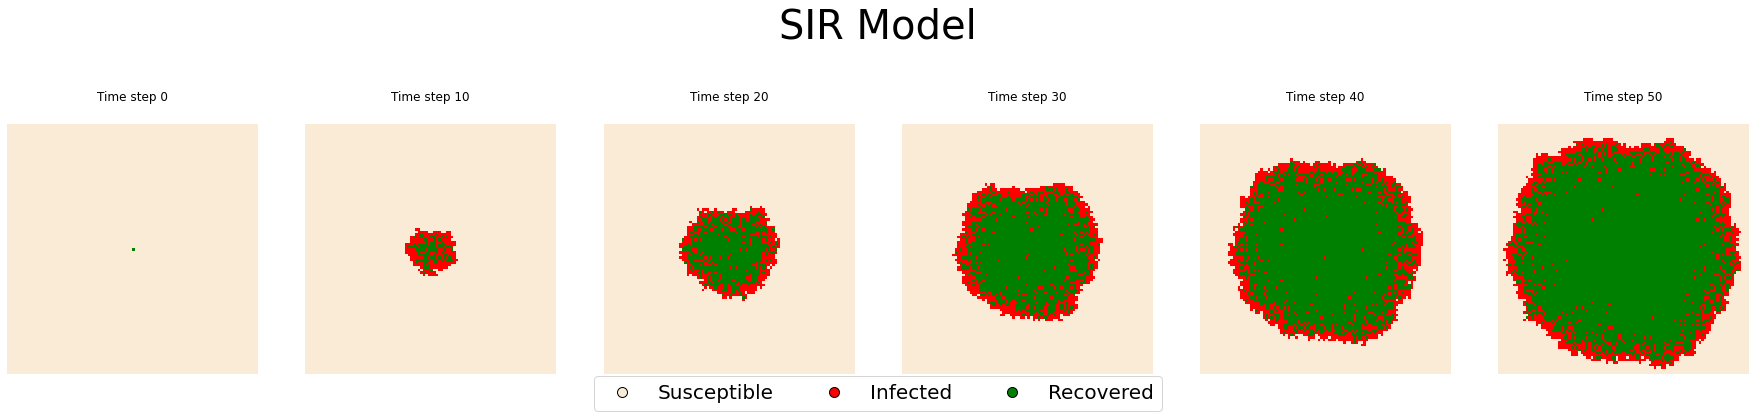

In [11]:
to_be_plotted = res[:50][::10]

fig, axs = plt.subplots(1, 6, figsize=(25, 5))  # Adjusting figsize for horizontal layout

# Define the colormap
colors = ['antiquewhite', 'red', 'green']
cmap = ListedColormap(colors)

# Plot the matrices
for i in range(5):
    axs[i].matshow(to_be_plotted[i].numpy(), cmap=cmap)
    axs[i].set_title(f'Time step {i*10}')
    axs[i].axis('off')  # Hide axes for better visualization

axs[-1].matshow(res[49].numpy(), cmap=cmap)
axs[-1].set_title(f'Time step {50}')
axs[-1].axis('off')  # Hide axes for better visualization


# Add a main title to the figure
fig.suptitle('SIR Model', fontsize=40, y=1.05)

# Adjust layout to prevent overlap
legend_labels = ['Susceptible', 'Infected', 'Recovered']
legend_colors = ['antiquewhite', 'red', 'green']
markers = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, markeredgecolor='black') for color in legend_colors]

# Create a new axis for the legend
fig.subplots_adjust(bottom=0.25)
fig.legend(markers, legend_labels, loc='lower center', fontsize=20, ncol=3, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("SIR_simulation_path")

plt.show()


In [12]:
num_epochs = 20
loss_list = []
loss_per_epoch = [[],[],[]]
predicted_parameter_inf = [[],[],[]]
predicted_parameter_rec = [[],[],[]]

##DEFINE REAL VALUES OF PARAMETERS
beta_infA = 0.5
beta_recA = 0.33

beta_infB = 0.33
beta_recB = 0.2

beta_infC = 0.2
beta_recC = 0.45


beta_inf_list = [beta_infA,beta_infB, beta_infC]
beta_rec_list = [beta_recA,beta_recB,beta_recC]

for test in range(len(beta_inf_list)):
    beta_inf_true = beta_inf_list[test]
    beta_rec_true = beta_rec_list[test]

    ##CREATE SYNTHETIC DATA
    result_paired = torch.empty(nSim*(tau-1),2,100,100)
    for i in range(tau*nSim):
        if i%tau==0:
            res[i] = grid
            continue
        next = SIR(res[i-1], beta_inf_true, beta_rec_true)
        res[i] = next

        #keeping the right dimensionality for DataLoader input
        if i%2 == 1:
            result_paired[i-1-i//tau] = torch.stack((res[i-1], next.reshape(100,100)))
    dataset = StochasticLatticeDataset(result_paired)

    # Create DataLoader
    data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
    model = MyModel()
    optimizer = optim.SGD(model.parameters(), lr=0.015)

    for epoch in range(num_epochs):
        ll = 0
        start_time = time.time()
        for inputs, targets in data_loader:
            inputs = inputs.to(torch.float32)
            targets = targets.to(torch.float32)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            gumbel_sample = sample_gumbel((3,inputs.size()[0],n, n))
            outputs = model(x = inputs, sample_gumbel = gumbel_sample, temperature = 0.1)


            # Compute loss
            loss = torch.mean(torch.mean((outputs-targets)**2, dim=(1,2)))

            loss_list.append(loss.item())
            ll+=loss.item()
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            predicted_parameter_inf[test].append(model.a.item())
            predicted_parameter_rec[test].append(model.b.item())


        end_time = time.time()
        epoch_time = end_time - start_time
        loss_per_epoch[test].append(ll)
        print(f'Epoch [{epoch+1}/{num_epochs}], Model: {test}, {model.a.item(), model.b.item()}, time: {epoch_time:.4f}')




Epoch [1/20], Model: 0, (0.9081827998161316, 0.6101027131080627), time: 13.6037
Epoch [2/20], Model: 0, (0.827774167060852, 0.4470408856868744), time: 13.3862
Epoch [3/20], Model: 0, (0.7582886815071106, 0.37892946600914), time: 13.5684
Epoch [4/20], Model: 0, (0.7004345655441284, 0.3499933183193207), time: 13.7287
Epoch [5/20], Model: 0, (0.6529496908187866, 0.33800357580184937), time: 13.6019
Epoch [6/20], Model: 0, (0.6151806712150574, 0.33339789509773254), time: 14.8439
Epoch [7/20], Model: 0, (0.5858542323112488, 0.330995112657547), time: 14.7641
Epoch [8/20], Model: 0, (0.5636273622512817, 0.33009210228919983), time: 15.2928
Epoch [9/20], Model: 0, (0.5468085408210754, 0.32963863015174866), time: 19.1538
Epoch [10/20], Model: 0, (0.5341272950172424, 0.32928627729415894), time: 18.8703
Epoch [11/20], Model: 0, (0.5252222418785095, 0.3291030526161194), time: 17.5904
Epoch [12/20], Model: 0, (0.5181301832199097, 0.3296477794647217), time: 15.6108
Epoch [13/20], Model: 0, (0.51320523

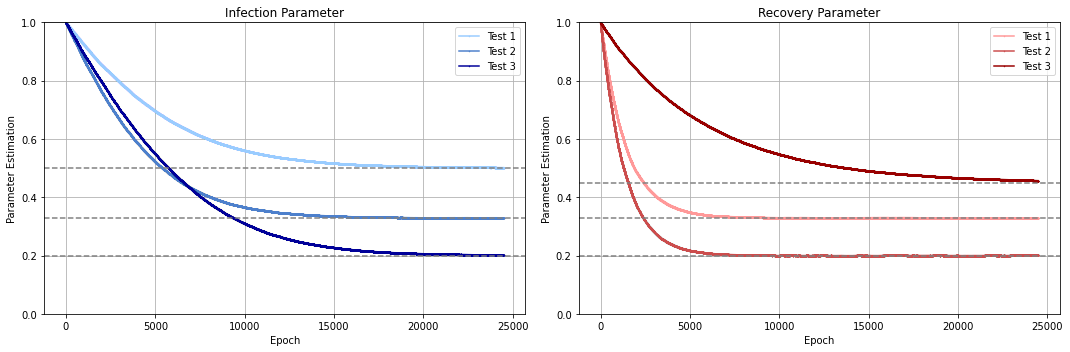

In [13]:
x_values = range(len(predicted_parameter_inf[0]))

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Changed to 1 row, 3 columns

# Define lightness levels for each color base
lightness_levels = [[(0.6, 0.8, 1), (0.3, 0.5, 0.8), (0, 0, 0.6)],  # Shades of blue
                    [(1, 0.6, 0.6), (0.8, 0.3, 0.3), (0.6, 0, 0)]]  # Shades of red
# Define marker size
marker_size = 0.5

# Plot the infection parameter
for i, lightness in enumerate(lightness_levels[0]):
    axs[0].plot(x_values, predicted_parameter_inf[i], marker='o', markersize=marker_size, color=lightness, label=f'Test {i+1}')
axs[0].set_title('Infection Parameter')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Parameter Estimation')
axs[0].set_ylim(0, 1)
axs[0].axhline(y=beta_infA, color='grey', linestyle='--')
axs[0].axhline(y=beta_infB, color='grey', linestyle='--')
axs[0].axhline(y=beta_infC, color='grey', linestyle='--')
axs[0].grid(True)
axs[0].legend()

# Plot the recovery parameter
for i, lightness in enumerate(lightness_levels[1]):
    axs[1].plot(x_values, predicted_parameter_rec[i], marker='o', markersize=marker_size, color=lightness, label=f'Test {i+1}')
axs[1].set_title('Recovery Parameter')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Parameter Estimation')
axs[1].set_ylim(0, 1)
axs[1].axhline(y=beta_recA, color='grey', linestyle='--')
axs[1].axhline(y=beta_recB, color='grey', linestyle='--')
axs[1].axhline(y=beta_recC, color='grey', linestyle='--')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()

# Show the plots
plt.savefig('SIR_param_estim.png')
plt.show()

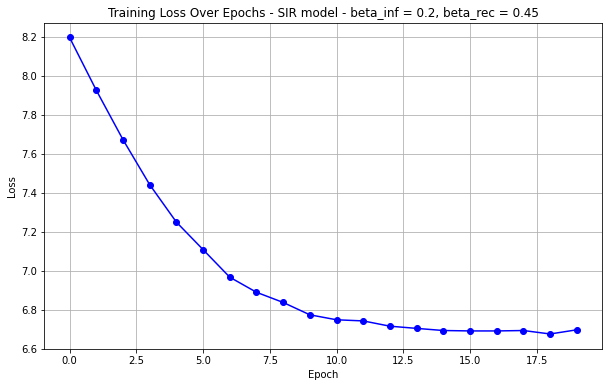

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(loss_per_epoch[2], marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Training Loss Over Epochs - SIR model - beta_inf = 0.2, beta_rec = 0.45')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Optionally add grid
plt.grid(True)

# Show the plot
plt.savefig("loss_SIR_model")
plt.show()
